데이트앱의 사용성 개선을 위한 서울시 상권 분류 클러스터링
 - 문제 상황: 서울시 행정동 단위의 지도를 사용성 개선을 위해 핫플레이스 기준으로 재분류하려고 함.
 - 데이터 분석 상황: 핫플레이스를 어떻게 구분할 것인가?
 - 분석 데이터: 단위 면적 내 접근성, 관광지, 쇼핑몰 등, 대학 수(어플 주 사용연령층 고려)
 - 분석 방식: 데이터 전처리 -> kmeans 클러스터링 및 시각화 -> 네이버 블로그 크롤링 -> 크롤링 데이터 기반으로 지도 위 지역명 부여

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np


pd.options.display.float_format = '{:.1f}'.format


In [35]:
#데이터 불러오기

code_name=pd.read_csv('code_name.csv') #상권코드 및 자치구명*

app_count=pd.read_csv('app_count.csv') #앱 내 업체수, 조회수, 찜수

bus_count=pd.read_csv('bus_count.csv') #면적내 버스정류장 수*
metro_count=pd.read_csv('metro_count.csv') #면적내 지하철역 수*
dep_count=pd.read_csv('dep_count.csv') #면적내 대형쇼핑몰 수*
tour_count=pd.read_csv('tour_count.csv') #면적내 관광지 수*
uni_count=pd.read_csv('uni_count.csv') #면적내 대학 수*

sales=pd.read_csv('sales.csv') #추정매출 23년도 1분기*
resident_population=pd.read_csv('resident_pp.csv', dtype='int') #거주인구*
floating_population=pd.read_csv('floating_pp.csv', dtype='int') #생활인구*

In [3]:
sales_r=pd.read_csv('C:\Python\Hot place\weekend.csv')
sales_r

,code,weedend
0,3001496,35
1,3001496,34
2,3001496,31
3,3001496,48
4,3001496,3
...,...,...
30903,3110001,31
30904,3110001,0
30905,3110001,33
30906,3110001,41


In [5]:
sales_df= sales_r.groupby('code')['weedend'].mean().reset_index()
sales_df

sales_df.to_csv('./weekend.csv', index=False)



,code,weedend
0,3001491,31.9
1,3001492,16.2
2,3001493,21.7
3,3001494,19.7
4,3001495,32.2
...,...,...
1623,3130323,30.3
1624,3130324,27.6
1625,3130325,21.1
1626,3130326,25.2


In [93]:
#매출 데이터 전처리
sales_df= sales.groupby('CODE')['SALES'].sum().reset_index()
sales_df

sales_df 

,CODE,SALES
0,3001491,81436059945.0
1,3001492,421796577685.0
2,3001493,114699793241.0
3,3001494,262634046151.0
4,3001495,377938089022.0
...,...,...
1623,3130323,14702130486.0
1624,3130324,6753992902.0
1625,3130325,4269693530.0
1626,3130326,16779555028.0


<AxesSubplot:>

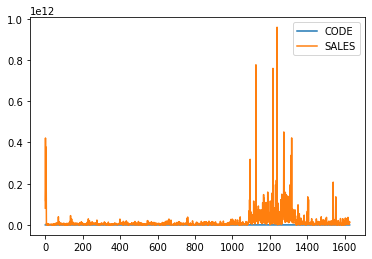

In [97]:
sales_df.plot()

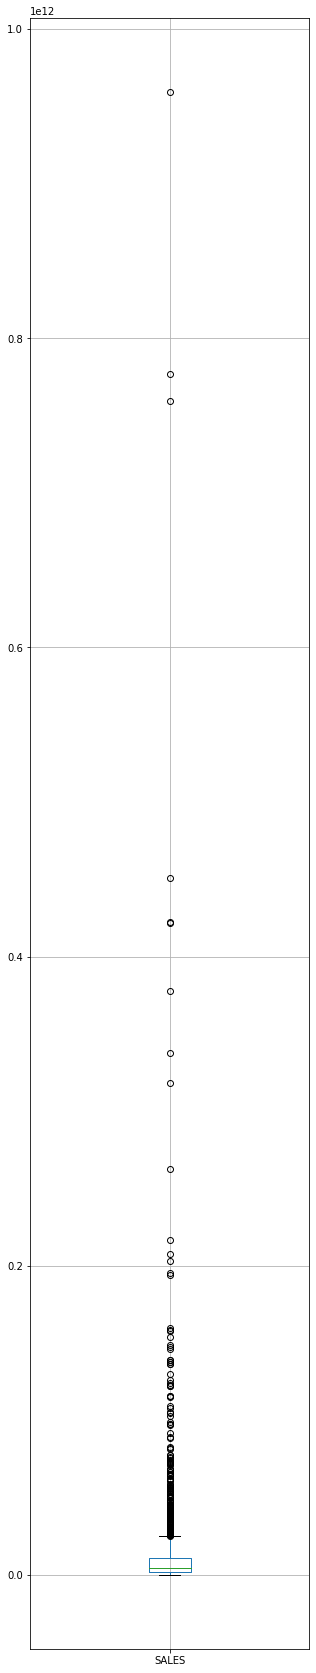

In [100]:
plt.figure(figsize=(5,30))
boxplot=sales_df.boxplot(column='SALES')
plt.show()

In [37]:
#거주인구 및 생활인구 전처리(2023년도 1분기)

df_population=pd.merge(floating_population, resident_population, how='outer', on='CODE')

df_population.drop('YEAR_x', axis=1, inplace=True) #필요없는 컬럼 제거
df_population.drop('QUARTER_x', axis=1, inplace=True)
df_population.drop('YEAR_y', axis=1, inplace=True)
df_population.drop('QUARTER_y', axis=1, inplace=True)

df_population

,CODE,TOTAL_FP,GEN10_FP,GEN20_FP,GEN3_FP,TOTAL_PP,GEN10_PP,GEN20_PP,GEN30_PP
0,3110227,3769536.0,569685.0,394121.0,549004.0,749.0,68.0,92.0,102.0
1,3110617,4281404.0,668341.0,560811.0,748555.0,2491.0,272.0,255.0,453.0
2,3110717,9033657.0,756121.0,1154731.0,1722320.0,8335.0,660.0,796.0,971.0
3,3110993,54575.0,7140.0,4114.0,11362.0,236.0,28.0,25.0,45.0
4,3110001,363858.0,66389.0,40379.0,38843.0,1011.0,116.0,130.0,122.0
...,...,...,...,...,...,...,...,...,...
1625,3001492,NaN,NaN,NaN,NaN,600.0,13.0,20.0,62.0
1626,3001493,NaN,NaN,NaN,NaN,1807.0,163.0,161.0,338.0
1627,3001494,NaN,NaN,NaN,NaN,1720.0,32.0,94.0,178.0
1628,3001495,NaN,NaN,NaN,NaN,5902.0,572.0,462.0,1173.0


In [38]:
#생활인구 대비 거주인구 컬럼 추가 및 추출

df_population['TOTAL_RATIO']=df_population['TOTAL_FP']//df_population['TOTAL_PP'] #전체비율
df_population['GEN10_RATIO']=df_population['GEN10_FP']//df_population['GEN10_PP'] #10대비율
df_population['GEN20_RATIO']=df_population['GEN20_FP']//df_population['GEN20_PP'] #20대비율
df_population['GEN30_RATIO']=df_population['GEN3_FP']//df_population['GEN30_PP'] #30대비율

df_population.isnull().sum() #결측치 확인
df_population.dropna(axis=0, inplace=True) #null값 행 제거

df_population=df_population[['CODE','TOTAL_RATIO','GEN10_RATIO','GEN20_RATIO','GEN30_RATIO']] #필요한 컬럼 추출
df_population

,CODE,TOTAL_RATIO,GEN10_RATIO,GEN20_RATIO,GEN30_RATIO
0,3110227,5032.0,8377.0,4283.0,5382.0
1,3110617,1718.0,2457.0,2199.0,1652.0
2,3110717,1083.0,1145.0,1450.0,1773.0
3,3110993,231.0,255.0,164.0,252.0
4,3110001,359.0,572.0,310.0,318.0
...,...,...,...,...,...
1084,3111086,281.0,672.0,143.0,232.0
1085,3111087,219.0,484.0,157.0,238.0
1086,3111088,552.0,1221.0,467.0,668.0
1087,3111089,361.0,604.0,280.0,371.0


In [103]:
#데이터 조인(코드기준, 버정, 쟈철, 쇼핑몰, 명소, 대학, 매출, 유동인구 비율t,1,2,3)

df_list=[code_name, bus_count, metro_count, dep_count, tour_count, uni_count, sales_df, df_population]
df_join=reduce(lambda x, y : pd.merge(x, y, how='outer', on='CODE'), df_list)

df_join.drop('TRDAR_SE_C', axis=1, inplace=True) #필요없는 컬럼 제거
df_join.isnull().sum() #결측치 탐색
df_join.dropna(axis=0, inplace=True) #null값 행 제거

df_join.to_csv('./preprocessing.csv', index=False)



In [43]:
#분석용데이터만 추출
df_join_scale=df_join[['BUS_COUNT', 'METRO_COUNT', 'DEP_COUNT', 'TP_COUNT', 'UNI_COUNT', 'SALES', 'TOTAL_RATIO', 'GEN10_RATIO', 'GEN20_RATIO','GEN30_RATIO']]
df_join_scale.head()


,BUS_COUNT,METRO_COUNT,DEP_COUNT,TP_COUNT,UNI_COUNT,SALES,TOTAL_RATIO,GEN10_RATIO,GEN20_RATIO,GEN30_RATIO
6,5,0,0,0,0,1058256714.0,359.0,572.0,310.0,318.0
7,1,1,1,0,0,8662201735.0,2433.0,5692.0,3236.0,3850.0
8,10,0,0,0,0,1562141652.0,358.0,625.0,290.0,286.0
9,2,0,0,0,0,653610126.0,7582.0,16475.0,8611.0,8971.0
10,6,0,0,2,0,1597006200.0,250.0,441.0,191.0,212.0


<AxesSubplot:>

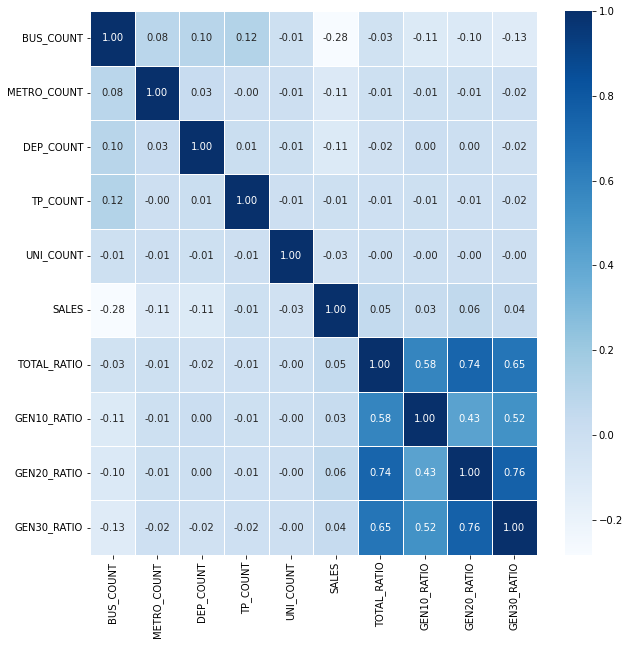

In [102]:
plt.figure(figsize=(10,10))
sns.heatmap(data = df_join_scale.corr(), annot=True,
fmt = '.2f', linewidths=.5, cmap='Blues')

In [49]:
df_join_scale.dtypes

BUS_COUNT        int64
METRO_COUNT      int64
DEP_COUNT        int64
TP_COUNT         int64
UNI_COUNT        int64
SALES            int32
TOTAL_RATIO      int32
GEN10_RATIO    float64
GEN20_RATIO    float64
GEN30_RATIO    float64
dtype: object

In [45]:
df_join_scale=df_join_scale.astype({'SALES':'int'})

In [47]:
df_join_scale=df_join_scale.astype({'TOTAL_RATIO':'int'})

In [50]:
df_join_scale_2=df_join[['BUS_COUNT', 'METRO_COUNT', 'DEP_COUNT', 'TP_COUNT', 'UNI_COUNT', 'SALES', 'TOTAL_RATIO']]
df_join_scale_2.head()

,BUS_COUNT,METRO_COUNT,DEP_COUNT,TP_COUNT,UNI_COUNT,SALES,TOTAL_RATIO
6,5,0,0,0,0,1058256714.0,359.0
7,1,1,1,0,0,8662201735.0,2433.0
8,10,0,0,0,0,1562141652.0,358.0
9,2,0,0,0,0,653610126.0,7582.0
10,6,0,0,2,0,1597006200.0,250.0


In [83]:
#주성분분석
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pca.fit(df_join_scale_2)

print(pca.components_.shape)

(2, 7)


In [51]:
#min-max
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
normal=scaler.fit_transform(df_join_scale_2)
normal=pd.DataFrame(normal, columns=df_join_scale_2.columns)
normal

,BUS_COUNT,METRO_COUNT,DEP_COUNT,TP_COUNT,UNI_COUNT,SALES,TOTAL_RATIO
0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.1,0.0,0.0,0.2,0.0
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1,0.0,0.0,0.0,0.0,0.0,0.0
4,0.3,0.0,0.0,0.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1055,0.1,0.0,0.0,0.0,0.0,0.1,0.0
1056,0.1,0.0,0.0,0.0,0.0,0.1,0.0
1057,0.1,0.0,0.0,0.0,0.0,0.1,0.0
1058,0.2,0.0,0.0,0.0,0.0,0.3,0.0


In [52]:
normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BUS_COUNT    1060 non-null   float64
 1   METRO_COUNT  1060 non-null   float64
 2   DEP_COUNT    1060 non-null   float64
 3   TP_COUNT     1060 non-null   float64
 4   UNI_COUNT    1060 non-null   float64
 5   SALES        1060 non-null   float64
 6   TOTAL_RATIO  1060 non-null   float64
dtypes: float64(7)
memory usage: 58.1 KB


In [62]:
#클러스터링
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)

In [63]:
kmeans.fit(normal)

KMeans(n_clusters=6)

In [64]:
cluster_1=kmeans.predict(normal)
cluster_1

array([2, 3, 1, ..., 2, 5, 2])

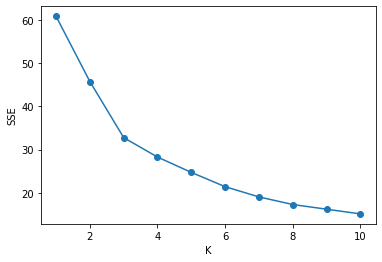

In [74]:
#엘보우포인트
def elbow(x):
    sse = []

    for i in range(1,11):
        km = KMeans(n_clusters=i,algorithm='auto', random_state=127)
        km.fit(x)
        sse.append(km.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()

elbow(normal)

In [75]:
df_cl = pd.DataFrame(cluster_1,columns=["cluster"])
df_cl

,cluster
0,2
1,3
2,1
3,4
4,0
...,...
1055,2
1056,4
1057,2
1058,5


In [81]:
df_join.head()

,SIGUNGU,CODE,CODE_NAME,BUS_COUNT,METRO_COUNT,DEP_COUNT,TP_COUNT,UNI_COUNT,SALES,TOTAL_RATIO,GEN10_RATIO,GEN20_RATIO,GEN30_RATIO
6,종로구,3110001,이북 5 도청사,5,0,0,0,0,1058256714.0,359.0,572.0,310.0,318.0
7,종로구,3110002,독립문역 1 번,1,1,1,0,0,8662201735.0,2433.0,5692.0,3236.0,3850.0
8,종로구,3110003,세검정초등학교,10,0,0,0,0,1562141652.0,358.0,625.0,290.0,286.0
9,종로구,3110004,대신고등학교,2,0,0,0,0,653610126.0,7582.0,16475.0,8611.0,8971.0
10,종로구,3110005,세검정,6,0,0,2,0,1597006200.0,250.0,441.0,191.0,212.0
